# Evaluation on the API Entity Extraction Module

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
def eval_precision(df):
    success = df[df.success]
    missing = df[df.stdout.map(lambda x: "has no attribute" in x)]
    wrong = df[df.stdout.map(lambda x: "Wrong" in x)]
    no_dep = df[df.stdout.map(lambda x: "No module named" in x)]
    runtime_error = df[~(df.success
                        | df.stdout.map(lambda x: "has no attribute" in x) 
                        | df.stdout.map(lambda x: "Wrong" in x)
                        | df.stdout.map(lambda x: "No module named" in x))]
    print(f"Number of Tested APIs: {len(df)} from {df.package.nunique()} packages")
    print(f"Number of Successful APIs: {len(df[df.success])}")
    print(f"Number of Unsuccessful APIs: {len(df[~df.success])}")
    print(f"{len(df)} tested APIs, {len(df[df.success])} successful APIs, {len(missing)} missing APIs, "
        f"{len(wrong)} wrong APIs, {len(no_dep)} no dependency, {len(runtime_error)} runtime error")
    #print(f"  Runtime Error (Correctness Unknown): {len(df[~df.success & df.reason.map(lambda x: 'Runtime' in x)])}")
    #print(f"  Incorrect API Entity: {len(df[~df.success & df.reason.map(lambda x: 'Symbol' in x)])}")
    #pprint(Counter(df[~df.success].reason))

    pkg2precision = defaultdict(lambda: {"Match": 0, "Missing": 0, "Wrong": 0, "No Dependency": 0, "Runtime Error": 0})
    for p in df[df.success].package:
        pkg2precision[p]["Match"] += 1
    for p in missing.package:
        pkg2precision[p]["Missing"] += 1
    for p in wrong.package:
        pkg2precision[p]["Wrong"] += 1
    for p in no_dep.package:
        pkg2precision[p]["No Dependency"] += 1
    for p in runtime_error.package:
        pkg2precision[p]["Runtime Error"] += 1
    for p, v in pkg2precision.items():
        s = sum(v.values())
        for k in v.keys():
            v[k] = v[k] / s
    pkg2precision = pd.DataFrame.from_dict(pkg2precision, orient="index").sort_values(by="Match", ascending=False)
    print(f"Weighted Precision: {sum(pkg2precision.Match)/len(pkg2precision.Match):.4f}") 
    fig, ax = plt.subplots(1, 1, figsize=(25, 4))
    pkg2precision.plot(kind="bar", stacked="True", mark_right=True, use_index=True, ax=ax)
    fig.autofmt_xdate()
    return fig
def eval_recall(df):
    passed = df[df.dynamic_type == df.extracted_type]
    missing = df[df.extracted_type == "Missing"]
    unresolved = df[df.extracted_type == "Unresolved"]
    loose_match = df[(df.dynamic_type != df.extracted_type) & (df.extracted_type == "Variable")]
    misalign = df[(df.dynamic_type != df.extracted_type) & (df.extracted_type != "Unresolved") & (df.extracted_type != "Variable") & (df.extracted_type != "Missing")]
    print(f"{df.package.nunique()} packages")
    print(f"{len(df)} Tested APIs, {len(passed)} Matched APIs, {len(loose_match)} Loose-Matched APIs, "
          f"{len(misalign)} Misaligned APIs, {len(unresolved)} Unresolved APIs, {len(missing)} Missing APIs")
    print(f"Overall Recall: {len(passed) / len(df):.4f}")
    
    #missing.to_csv("apis_recall_missing.csv", index=False)
    #misalign.to_csv("apis_recall_misalign.csv", index=False)

    pkg2recall = defaultdict(lambda: {"Match": 0, "Loose Match": 0, "Unresolved": 0, "Mismatch": 0, "Missing": 0})
    for p in passed.package:
        pkg2recall[p]["Match"] += 1
    for p in unresolved.package:
        pkg2recall[p]["Unresolved"] += 1
    for p in misalign.package:
        pkg2recall[p]["Mismatch"] += 1
    for p in loose_match.package:
        pkg2recall[p]["Loose Match"] += 1
    for p in missing.package:
        pkg2recall[p]["Missing"] += 1
    for p, v in pkg2recall.items():
        s = sum(v.values())
        for k in v.keys():
            v[k] = v[k] / s
    pkg2recall = pd.DataFrame.from_dict(pkg2recall, orient="index").sort_values(by="Match", ascending=False)
    print(f"Weighted Recall: {sum(pkg2recall.Match)/len(pkg2recall.Match):.4f}") 
    fig, ax = plt.subplots(1, 1, figsize=(25, 4))
    pkg2recall.plot(kind="bar", stacked="True", mark_right=True, use_index=True, ax=ax)
    fig.autofmt_xdate()
    return fig

Number of Tested APIs: 3889 from 91 packages
Number of Successful APIs: 3461
Number of Unsuccessful APIs: 428
3889 tested APIs, 3461 successful APIs, 64 missing APIs, 6 wrong APIs, 289 no dependency, 70 runtime error
Weighted Precision: 0.8895


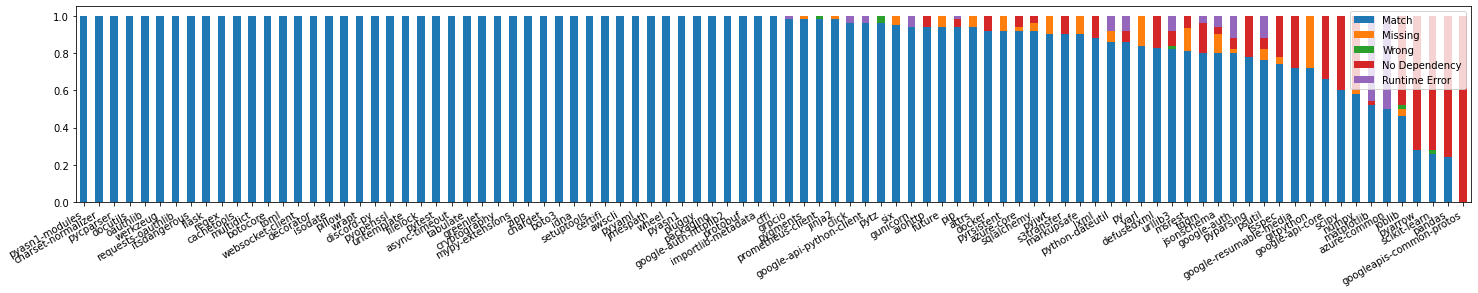

In [20]:
df = pd.read_csv("evaluation/apis_precision.csv").fillna("")
fig = eval_precision(df)
fig.savefig("evaluation/figs/apis_precision_by_pkg.png", bbox_inches="tight")

82 packages
5104 Tested APIs, 3868 Matched APIs, 523 Loose-Matched APIs, 12 Misaligned APIs, 636 Unresolved APIs, 65 Missing APIs
Overall Recall: 0.7578
Weighted Recall: 0.8034


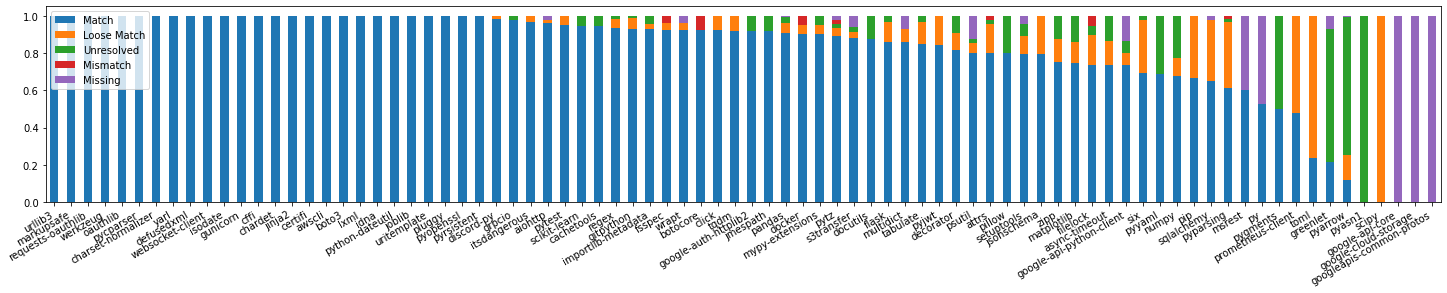

In [5]:
df = pd.read_csv("evaluation/apis_recall.csv").fillna("")
fig = eval_recall(df)
fig.savefig("evaluation/figs/apis_recall_by_pkg.png", bbox_inches="tight")